# Probabilistic error cancellation with shaded lightcones
##  Background
This tutorial demonstrates how to mitigate errors by using the Shaded lightcone (SLC) addon. This addon is an evolution of the [probabilistic error cancellation (PEC) technique](https://quantum.cloud.ibm.com/docs/guides/error-mitigation-and-suppression-techniques#probabilistic-error-cancellation-pec), wherein a user learns the noise of unique layers in a circuit and then cancels out the noise by applying single-qubit gates and post-processing techniques. Compared to other methods, PEC offers more robust bounds on the bias of the mitigated result, but tends to suffer from a higher overhead in terms of QPU time. During PEC, to compensate for attenuation of the expectation value by noise, the average result is rescaled by a factor of $\gamma = \exp(\sum_{l,\sigma} 2\lambda_{l,\sigma})$, where $\lambda_{l,\sigma}$ is the learned noise rate of error Pauli $\sigma$ at layer $l$ in the circuit. This rescaling increases the variance by a factor of $\gamma^2$, and thus also multiplies the number of circuit executions needed on the QPU by $\gamma^2$, which we call the sampling cost or sampling overhead. Because $\gamma$ grows exponentially, PEC is often limited to shallow or few-qubit circuits. Learn more about PEC in [Probabilistic error cancellation with sparse Pauli-Lindblad models on noisy quantum processors.](https://arxiv.org/abs/2201.09866) 

If we can identify errors that do not need to be mitigated, we can decrease this sampling cost exponentially. A first step in this direction is implementing locally aware error mitigation, which uses a quickly computable conventional “lightcone” to reduce the PEC overhead by bounding an observable's sensitivity to errors throughout the circuit, extending the feasibility of PEC to larger scales for some problems. Errors outside of this lightcone cannot affect the measured outcome and can therefore be excluded from the error cancellation procedure. This exclusion decreases the sampling overhead, in some cases substantially, without introducing additional bias. In particular, for measuring a local observable $O$ of a fixed-depth circuit, the required sampling overhead eventually plateaus when scaling the number of qubits in the circuit (see Fig. 2b in [Locality and Error Mitigation of Quantum Circuits.](https://arxiv.org/abs/2303.06496))

Shaded lightcones (SLC) go further, using classical simulations to more tightly bound the sensitivity to errors throughout the circuit. This trades some QPU time for CPU time and reduces the sampling overhead needed to renormalize the bias. Instead of a hard cutoff, each potential error in the circuit is assigned a graded “shade” that upper-bounds the susceptibility of the observable to that error. This refined characterization allows for more efficient, targeted applications of PEC with reduced variance, while giving the user the ability to controllably tune the bias in the observable estimation. See [Lightcone shading for classically accelerated quantum error mitigation](https://arxiv.org/abs/2409.04401) for more details.

Our workflow for the SLC addon leverages the new Samplomatic and Executor framework, allowing users to have more modular control of execution settings for error suppression and mitigation while retaining ease of use for advanced users. For a deeper understanding of the benefits of this framework and its general features, refer to the [Hello samplomatic](https://github.com/qiskit-community/qdc-challenges-2025/blob/main/day3_tutorials/Track_A/hello_samplomatic/Samplomatic%20-%20Hello%20World.ipynb) tutorial.

### Workflow for lightcone shading, noise learning, and anti-noise injection
For modeling the QPU's noise, we chose to use a sparse Pauli-Lindblad noise model with 1- and 2-qubit Pauli error rates, locally generated on each qubit and edge of the device. With this choice, the SLC error-mitigation workflow presented in this tutorial is as follows:

a. CPU — Bound per-error impact of 1- and 2-qubit Pauli errors

  1. Forward propagation (bound effect on observable). Propagate each error to the end of the circuit and compute its commutator with the observable.  
      - Truncate operator terms during evolution to keep computation tractable.  
      - Further tighten these bounds by a loose back-propagation of the observable based on quantum speed limits.
  2. Backward propagation (bound effect on initial state). Propagate each error to the start of the circuit and compute its commutator with the initial state.

b. QPU — Learn noise rates.  Use `NoiseLearner` to estimate rates of the Pauli-Lindblad noise model.

c. CPU — Prioritize mitigation

  1. Update merged bounds with learned noise rates. Combine forward and backward bounds that were previously computed and update them with learned noise rates.  
  2. Rank noise components to mitigate by using the computed bounds and learned rates. Prioritize each possible noise error based on its estimated impact on bias and the associated expense to correct. 

d. QPU — Insert antinoise and run. Execute the circuit of interest with antinoise (inverse noise) specified by using `Box` annotations.

e. CPU — Estimate observable. Compute the expectation value, applying measurement-based post-selection to reduce non-Markovian noise impact.

### Noise learning overview
Noise learning is a common step in several error-mitigation methods, carried out by the [NoiseLearner](https://quantum.cloud.ibm.com/docs/en/guides/noise-learning), and can be seen in our [PEA error mitigation](https://quantum.cloud.ibm.com/docs/tutorials/probabilistic-error-amplification) tutorial, as well as our [Propagated noise absorption (PNA) tutorial](https://github.com/qiskit-community/qdc-challenges-2025/blob/main/day3_tutorials/Track_A/pna/propagated_noise_absorption.ipynb). In `NoiseLearnerV3`, a user can specifically identify the to-be-learned noise layers as [`CircuitInstruction`](https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.circuit.CircuitInstruction) objects, which allows users to compute the desired SLC noise bounds for each layer in the manner described above. The learned Pauli-Lindblad model provides coefficients to be used in the PEC-SLC prioritization. The way in which the gates are collected into layers can be determined by using `generate_boxing_pass_manager` and `unique_2q_instructions` convenience functions, and then fed into the SLC utility function `generate_noise_model_paulis`, as described in Step 2 below.

| **Part 1** | **Part 2** | **Part 3** |
|-----------|-----------|-----------|
| Pauli-twirl two-qubit gate layers | Repeat identity pairs of layers and learn noise | Derive a fidelity (error for each noise channel) |
| ![paulitwirling.png](exp_data/paulitwirl.png) | ![learnlayer.png](exp_data/learnlayer.png) | ![curvefit.png](exp_data/curvefit.png) |

### Post-processing overview
After executing on quantum hardware by using the Samplomatic and Executor framework, we convert our bitstring measurements into the desired observable value. In the case of our mirrored Ising circuit, we will ideally get a measured observable of 1, as all qubits should ideally return to their starting point of $\ket{0}$. When computing the observable value with our `expectation_values` function, we will apply a few post-processing techniques that reduce noise impact. This includes removing shots affected by non-Markovian noise, readout-error mitigation, as well as accounting for details of our PEC implementation. Details are discussed in Step 4 below.


## Requirements
Before starting this tutorial, ensure that you have the following packages installed:

- Qiskit Runtime Executor Preview and SDK (`pip install "qiskit-ibm-runtime @ git+https://github.com/Qiskit/qiskit-ibm-runtime.git@executor_preview"`)
- Qiskit addon Shaded lightcone 0.1 (`pip install "qiskit-addon-slc~=0.1.0`")
- Qiskit addon utils (`pip install "qiskit-addon-utils~=0.3.0"`)
- Samplomatic v0.13 or more(`pip install samplomatic`)
- Qiskit Visualization support (`pip install "qiskit[visualization]"`)

## Step 0. Setup
First, import the packages and functions needed to run this notebook successfully.

In [1]:
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(module)s %(message)s")

# Setting this value prevents itertools.starmap deadlock on UNIX systems
from multiprocessing import set_start_method

set_start_method("spawn")

# Needed to prevent PySCF from parallelizing internally (SLC only)
%set_env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
import pickle

import numpy as np
import samplomatic
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import PassManager, generate_preset_pass_manager
from qiskit_addon_slc.bounds import (
    compute_backward_bounds,
    compute_forward_bounds,
    compute_local_scales,
    merge_bounds,
    tighten_with_speed_limit,
)
from qiskit_addon_slc.utils import generate_noise_model_paulis, map_modifier_ref_to_ref
from qiskit_addon_slc.visualization import draw_shaded_lightcone
from qiskit_addon_utils.exp_vals.expectation_values import executor_expectation_values
from qiskit_addon_utils.exp_vals.measurement_bases import get_measurement_bases
from qiskit_addon_utils.noise_management import gamma_from_noisy_boxes, trex_factors
from qiskit_addon_utils.noise_management.post_selection import PostSelector
from qiskit_addon_utils.noise_management.post_selection.transpiler.passes import (
    AddPostSelectionMeasures,
    AddSpectatorMeasures,
)
from qiskit_ibm_runtime import Executor, QiskitRuntimeService, QuantumProgram
from qiskit_ibm_runtime.noise_learner_v3 import NoiseLearnerV3
from qiskit_ibm_runtime.options import NoiseLearnerV3Options
from samplomatic.transpiler import generate_boxing_pass_manager
from samplomatic.utils import find_unique_box_instructions

2026-02-02 11:12:50,345 INFO base_tasks Pass: UnrollCustomDefinitions - 0.05913 (ms)
2026-02-02 11:12:50,346 INFO base_tasks Pass: BasisTranslator - 0.03195 (ms)


## Step 1. Map the problem
For ease of demonstration, we select a 1D mirror Ising chain. The 1D Ising chain gives a nicely dense circuit structure, which is convenient for showcasing PEC implementations. A mirror circuit makes it straightforward to know the expected outcome (namely, we should measure an observable of 1).

Further, we want to run a mirror circuit, so for every gate in the second half of the circuit, there needs to be an inverse gate in the first half. As the measured observable **$<X_6 Z_{13}>$** has non-Z-basis measurements, and the executor accounts for the desired basis at the end of the circuit, we provide a `prepare_basis` function that inserts the appropriate gates at the start of the mirror circuit. This detail is specific to our mirror-circuit demonstration. The `get_measurement_bases` function allows us to easily identify which gates are needed and where to append them, as well as keeping track of qubit index subtleties arising from conventions in `box` annotation as discussed in the "Prepare canonical bases measurements" section.

In [3]:
num_qubits = 14
target_obs_sparse = [("XZ", [4, 9], 1.0)]

In [4]:
observable = SparsePauliOp.from_sparse_list(target_obs_sparse, num_qubits=num_qubits)

In [5]:
bases_virt, reverser_virt = get_measurement_bases(observable)

In [6]:
num_trotter_steps = 10
rx_angle = np.pi / 4

In [7]:
def construct_ising_circuit(
    num_qubits: int, num_trotter_steps: int, rx_angle: float, barrier: bool = True
) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    for _step in range(num_trotter_steps):
        circuit.rx(rx_angle, range(num_qubits))
        if barrier:
            circuit.barrier()
        for first_qubit in (1, 2):
            for idx in range(first_qubit, num_qubits, 2):
                # equivalent to Rzz(-pi/2):
                circuit.sdg([idx - 1, idx])
                circuit.cz(idx - 1, idx)
        if barrier:
            circuit.barrier()

    return circuit


def prepare_basis(circuit: QuantumCircuit, basis: list[int]) -> QuantumCircuit:
    # basis is a list of integer values from 0 to 3. These map to the basis measurement as:
    # 0 = I; 1 = Z; 2 = X; 3 = Y
    assert len(basis) == circuit.num_qubits

    out_circ = circuit.copy_empty_like()
    for qb, bas in enumerate(basis):
        if bas in {0, 1}:
            continue
        if bas == 2:
            out_circ.h(qb)
        elif bas == 3:
            out_circ.rx(-np.pi / 2, qb)

    out_circ.barrier()
    out_circ.compose(circuit, inplace=True)
    return out_circ


def mirror_circuit(circuit: QuantumCircuit, *, inverse_first: bool = False) -> QuantumCircuit:
    mirror_circ = circuit.copy_empty_like()
    mirror_circ.compose(circuit.inverse() if inverse_first else circuit, inplace=True)
    mirror_circ.barrier()
    mirror_circ.compose(circuit if inverse_first else circuit.inverse(), inplace=True)
    mirror_circ.measure_active()
    return mirror_circ

In [8]:
# Instantiate circuit
circuit = construct_ising_circuit(num_qubits, num_trotter_steps, rx_angle, barrier=False)
mirrored_circuit = mirror_circuit(circuit, inverse_first=True)
mirrored_circuit = prepare_basis(mirrored_circuit, bases_virt[0])

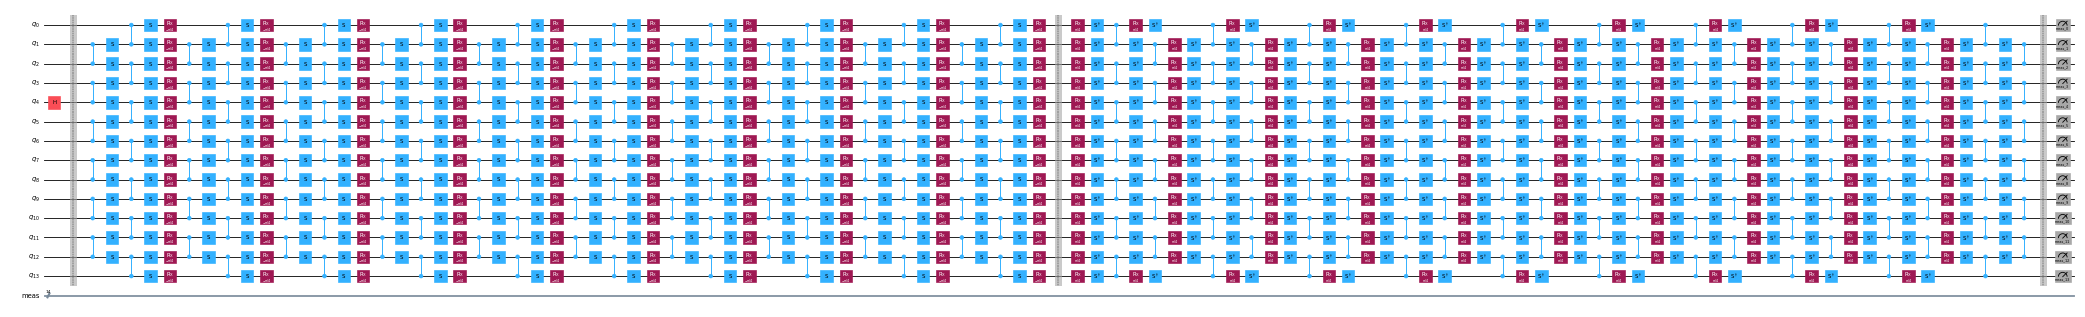

In [9]:
mirrored_circuit.draw("mpl", fold=-1, scale=0.3, idle_wires=False, measure_arrows=False)

## Step 2. Optimize
We will optimize details associated with the circuit to be run, the observable to be measured, and the noise-learning parameters. As a starting point, we ensure that we instantiate a backend with fractional gates turned on as an option. These fractional gates will allow for greater sensitivity in some of our post-selection filtering.


In [10]:
# token = "<YOUR_TOKEN>"
# instance = "<YOUR_INSTANCE>"

# # This is used to retrieve shared results
# shared_service = QiskitRuntimeService(
#     channel="ibm_quantum_platform",
#     token=token,
#     instance=instance,
# )

# This is used to run on real hardware
service = QiskitRuntimeService()

management.get:INFO:2026-02-02 11:12:55,937: Loading default saved account


In [11]:
# backend_name = service.least_busy().name
backend_name = 'ibm_marrakesh'

In [12]:
backend_name

'ibm_marrakesh'

In [13]:
backend = service.backend(backend_name, use_fractional_gates=True)

First, we will transpile our circuit to ISA instructions, [as required for execution on our QPUs](https://www.ibm.com/quantum/blog/isa-circuits). For the data collected in this experiment, we hand select our qubits based on evaluation of the highest quality chain.

In [14]:
# layout = [44, 45, 46, 47, 57, 67, 68, 69, 78, 89, 88, 87, 97, 107, 106, 105, 104, 103, 96, 83]

In [15]:
isa_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

isa_circuit = isa_pm.run(mirrored_circuit)
layout = isa_circuit.layout.final_index_layout()

isa_observable = observable.apply_layout(layout, num_qubits=isa_circuit.num_qubits)

2026-02-02 11:13:03,220 INFO base_tasks Pass: ContainsInstruction - 0.00715 (ms)
2026-02-02 11:13:03,221 INFO base_tasks Pass: UnitarySynthesis - 0.00787 (ms)
2026-02-02 11:13:03,221 INFO base_tasks Pass: HighLevelSynthesis - 0.02384 (ms)
2026-02-02 11:13:03,221 INFO base_tasks Pass: BasisTranslator - 0.08988 (ms)
2026-02-02 11:13:03,221 INFO base_tasks Pass: ElidePermutations - 0.00691 (ms)
2026-02-02 11:13:03,222 INFO base_tasks Pass: RemoveDiagonalGatesBeforeMeasure - 0.01383 (ms)
2026-02-02 11:13:03,222 INFO base_tasks Pass: RemoveIdentityEquivalent - 0.00882 (ms)
2026-02-02 11:13:03,222 INFO base_tasks Pass: InverseCancellation - 0.13185 (ms)
2026-02-02 11:13:03,222 INFO base_tasks Pass: ContractIdleWiresInControlFlow - 0.00310 (ms)
2026-02-02 11:13:03,223 INFO base_tasks Pass: CommutativeCancellation - 0.33593 (ms)
2026-02-02 11:13:03,224 INFO base_tasks Pass: ConsolidateBlocks - 0.76270 (ms)
2026-02-02 11:13:03,224 INFO base_tasks Pass: Split2QUnitaries - 0.00405 (ms)
2026-02-02

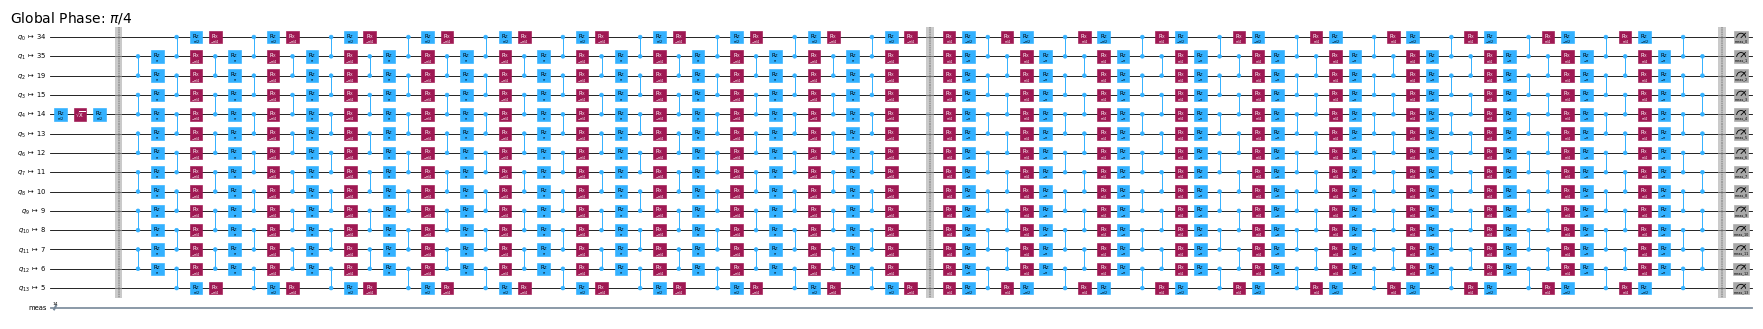

In [16]:
wire_order = layout + [q for q in range(isa_circuit.num_qubits) if q not in layout]
isa_circuit.draw(
    "mpl", fold=-1, scale=0.3, idle_wires=False, wire_order=wire_order, measure_arrows=False
)

### Box the circuit
For ease of implementation, we will utilize the `generate_boxing_pass_manager` transpilation pass, which places the circuit instructions into annotated boxes. These boxes clearly indicate where, in the case of PEC, antinoise should be injected into the circuit. For details on settings, refer to the [Samplomatic documentation.](https://qiskit.github.io/samplomatic/)

Note that the SLC workflow the use of `inject_noise_strategy="individual_modification"` later in the process because this allows us to  uniquely identify each `BoxOp` in the circuit.

The `find_unique_box_instructions` function iterates through the provided boxed circuit and identifies those that have unique 2Q layers or measurements, for the purpose of noise learning and noise injection.

In [17]:
# Box circuit with Twirl and InjectNoise annotations
boxes_pm = generate_boxing_pass_manager(
    twirling_strategy="active",
    inject_noise_strategy="individual_modification",
    inject_noise_targets="gates",
    measure_annotations="all",
)


boxed_circuit = boxes_pm.run(isa_circuit)

# Find the unique instructions (layers) from boxed circuit
unique_2q_instructions = find_unique_box_instructions(
    boxed_circuit, normalize_annotations=None, undress_boxes=True
)

2026-02-02 11:13:04,720 INFO base_tasks Pass: GroupGatesIntoBoxes - 4.42314 (ms)
2026-02-02 11:13:04,722 INFO base_tasks Pass: GroupMeasIntoBoxes - 1.79696 (ms)
2026-02-02 11:13:04,725 INFO base_tasks Pass: AddTerminalRightDressedBoxes - 2.86102 (ms)
2026-02-02 11:13:04,728 INFO base_tasks Pass: RemoveBarriers - 1.97196 (ms)
2026-02-02 11:13:04,731 INFO base_tasks Pass: AbsorbSingleQubitGates - 2.87008 (ms)
2026-02-02 11:13:04,737 INFO base_tasks Pass: AddInjectNoise - 5.30720 (ms)


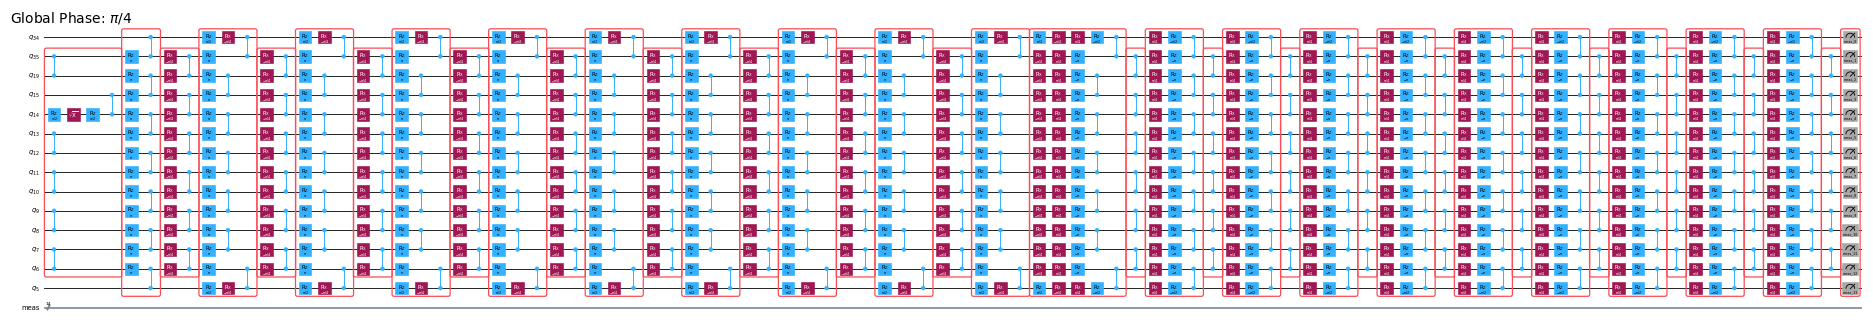

In [18]:
boxed_circuit.draw(
    "mpl", fold=-1, scale=0.3, idle_wires=False, wire_order=wire_order, measure_arrows=False
)

### Prepare canonical bases measurements
Due to how the qubits are labeled when identifying unique 2Q layers, one must take special care to keep track of qubit ordering. Below, we introduce the notion of `canonical_qubits` as a means to appropriately update the qubit ordering when providing it to the executor, as a result of how qubit order is captured when boxing circuits and finding unique instructions. See the [Qubit ordering convention](https://qiskit.github.io/samplomatic/guides/samplex_io.html#qubit-ordering-convention) documentation for details.

In [19]:
# Determine the canonical qubits order
meas_box = boxed_circuit.data[-1]
canonical_qubits = [
    idx for idx, qubit in enumerate(boxed_circuit.qubits) if qubit in meas_box.qubits
]

# map canonical qubit to physical (isa) qubit
c_2_p = {c: p for c, p in enumerate(canonical_qubits)}
# map physical (isa) qubit to virtual qubit (index in original circuit)
p_2_v = {p: v for v, p in enumerate(layout)}
# compute map between virtual and canonical qubit indices.
c_2_v = {c: p_2_v[p] for c, p in c_2_p.items()}

assert len(c_2_v) == num_qubits

bases_canon = [
    np.array([base_i[c_2_v[c]] for c in range(num_qubits)], dtype=np.uint8) for base_i in bases_virt
]

### Workflow for lightcone shading, noise learning, and anti-noise injection

> **Note**: For the implementation of SLC-PEC in this tutorial, we run SLC bound computations **before** the noise learning has been completed, so the to-be-mitigated circuit is run as close in time as possible to the learned noise model. In principle, this workflow can be further enhanced to execute simultaneously.  Namely, a noise-learning job is run while, in parallel, noise bounds are estimated. For an arbitrary quantum circuit, the noise-bound computation can scale with a weakly exponential dependence.  As such, it might be prudent to use parallelized execution when trying to maximize the workflow's efficiency. To this end, we briefly demonstrate this by including cluster-based (128-thread) resources and showing how you can achieve a more refined set of bounds for a provided circuit when constrained to equal computation-time limits, compared to our laptop (8 threads). Furthermore, although not implemented in this workflow, you can parallelize the QPU executions for noise learning and noise-bound computations to achieve the most efficient workflow.


#### Predict to-be-learned noise-model Paulis

The `generate_noise_model_paulis` function goes through each boxed layer of the provided circuit and generates all relevant weight-one and weight-two Pauli terms, taking into account the circuit's qubit connectivity, and selecting terms that are relevant to the active nodes and edges. These terms are then used to compute forward and backward noise bounds.

In [20]:
noise_model_paulis = generate_noise_model_paulis(
    unique_2q_instructions, backend.coupling_map, boxed_circuit
)

In [21]:
noise_model_rates = {ref: None for ref in noise_model_paulis}

##### a. Compute and tighten forward bounds

The `compute_forward_bounds` function evaluates the commutation relations between the gates in each layer and the above-generated Pauli terms in terms of how forward-propagation errors affect the desired observable $A$. For gates that commute with the Pauli terms, nothing is done. For Clifford gates, they are pushed toward the beginning of the circuit. For non-Clifford gates, we approximate their influence on the target observables to later be prioritized for noise cancelation (after all bounds have been merged). This bound is achieved by first applying the L2 norm (namely, the square root of the sum of squares of the relevant Pauli-term coefficients). When there are too many qubit terms involved, we revert to a looser bound that uses the triangle inequality.

#### Laptop-level resources

In [22]:
slc_atol = 1e-8
slc_eigval_max_qubits = 18
slc_evolution_max_terms = 1000
slc_num_processes = 8
slc_timeout = 60*5

In [23]:
forward_bounds = compute_forward_bounds(
    boxed_circuit,
    noise_model_paulis,
    isa_observable,
    evolution_max_terms=slc_evolution_max_terms,
    eigval_max_qubits=slc_eigval_max_qubits,
    atol=slc_atol,
    num_processes=slc_num_processes,
    timeout=slc_timeout,
)

2026-02-02 11:13:07,256 INFO forward Evolving Pauli error terms forwards through the circuit.
2026-02-02 11:13:07,261 INFO forward Modelling errors as though they happen *after* each noise layer.
2026-02-02 11:13:07,262 INFO remove_measure Removing ANY Measure operations from the provided circuit!
2026-02-02 11:13:07,381 INFO commutator_bounds Starting to spawn bound computation tasks
2026-02-02 11:13:07,383 INFO circuit_iter Noisy box 'm39'
2026-02-02 11:13:07,398 INFO circuit_iter Noisy box 'm38'
2026-02-02 11:13:07,420 INFO circuit_iter Noisy box 'm37'
2026-02-02 11:13:07,432 INFO circuit_iter Noisy box 'm36'
2026-02-02 11:13:07,477 INFO circuit_iter Noisy box 'm35'
2026-02-02 11:13:07,510 INFO circuit_iter Noisy box 'm34'
2026-02-02 11:13:07,561 INFO circuit_iter Noisy box 'm33'
2026-02-02 11:13:07,572 INFO circuit_iter Noisy box 'm32'
2026-02-02 11:13:07,613 INFO circuit_iter Noisy box 'm31'
2026-02-02 11:13:07,622 INFO circuit_iter Noisy box 'm30'
2026-02-02 11:13:07,680 INFO cir

#### Visualize the SLC for manual inspection

You can interpret the behavior of the shaded bounds by examining how the measurements and Pauli terms interact with the local errors. These patterns are characteristic of this kicked Ising Hamiltonian time-evolution problem and also appear in the paper [Lightcone Shading for Classically Accelerated Quantum Error Mitigation](https://arxiv.org/abs/2409.04401), with several telltale features:

- We can clearly distinguish the two cones arising from the two non-identity Paulis in the observable.
- We can see that the X measurement on qubit 6 commutes with the X error in the rightmost layer.
- We can see that the Z Pauli on qubit 13 commutes with the Z error in the rightmost layer.
- When we reach the timeout specified above, the remaining layers to the left are filled entirely with trivial bounds of two.




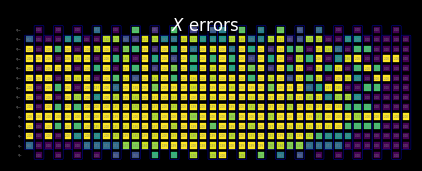

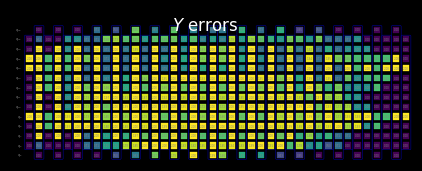

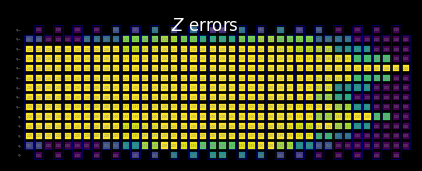

In [24]:
for p in "XYZ":
    display(
        draw_shaded_lightcone(
            boxed_circuit,
            forward_bounds,
            noise_model_paulis,
            pauli_filter=p,
            scale=0.15,
            fold=-1,
            idle_wires=False,
            wire_order=wire_order,
            measure_arrows=False,
        )
    )

#### b. Compute and tighten forward bounds
We next tighten the bounds by using the `tighten_with_speed_limit` function, which tracks how the observable spreads backward through the circuit and uses that spread to place upper bounds on the effect of each noise operator, taking the smaller of the forward bound just computed, and the backward-propagation bound.

In [25]:
forward_bounds_tighter = tighten_with_speed_limit(
    forward_bounds, boxed_circuit, noise_model_paulis, isa_observable
)

2026-02-02 11:16:55,893 INFO speed_limit Tighting bounds using information propagation speed limits
2026-02-02 11:16:55,895 INFO speed_limit Modelling errors as though they happen *after* each noise layer.
2026-02-02 11:16:55,940 INFO remove_measure Removing ANY Measure operations from the provided circuit!
2026-02-02 11:16:55,953 INFO circuit_iter Noisy box 'm39'
2026-02-02 11:16:55,955 INFO circuit_iter Noisy box 'm38'
2026-02-02 11:16:55,959 INFO circuit_iter Noisy box 'm37'
2026-02-02 11:16:55,961 INFO circuit_iter Noisy box 'm36'
2026-02-02 11:16:55,964 INFO circuit_iter Noisy box 'm35'
2026-02-02 11:16:55,965 INFO circuit_iter Noisy box 'm34'
2026-02-02 11:16:55,969 INFO circuit_iter Noisy box 'm33'
2026-02-02 11:16:55,970 INFO circuit_iter Noisy box 'm32'
2026-02-02 11:16:55,974 INFO circuit_iter Noisy box 'm31'
2026-02-02 11:16:55,975 INFO circuit_iter Noisy box 'm30'
2026-02-02 11:16:55,978 INFO circuit_iter Noisy box 'm29'
2026-02-02 11:16:55,979 INFO circuit_iter Noisy box '

#### Visualize the SLC for manual inspection

We can further tighten the bounds by accounting for lightcone limitation. In principle, this gives us a smoother transition from the computed bounds to the trivial bounds set forth after the timeout was reached. Here, the effect is not as visible because the lightcones have already reached the edge of the circuit. 


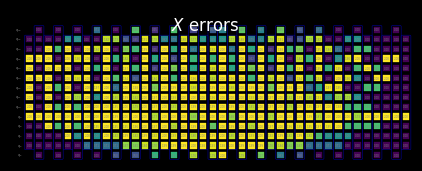

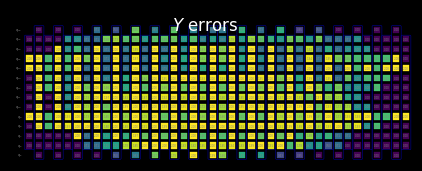

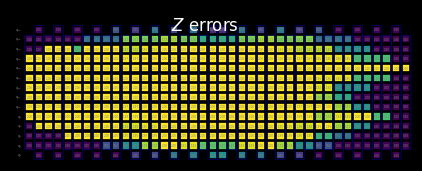

In [26]:
for p in "XYZ":
    display(
        draw_shaded_lightcone(
            boxed_circuit,
            forward_bounds_tighter,
            noise_model_paulis,
            pauli_filter=p,
            scale=0.15,
            fold=-1,
            idle_wires=False,
            wire_order=wire_order,
            measure_arrows=False,
        )
    )

#### c. Compute backward bounds

This part of noise prediction evaluates how an error at a particular layer can affect the input state $\rho$. The `compute_backward_bounds` function first inverts the circuit, removes measurement gates, and then proceeds with a similar analysis as was done for the forward-bound computations.

In [27]:
backward_bounds = compute_backward_bounds(
    boxed_circuit,
    noise_model_paulis,
    evolution_max_terms=slc_evolution_max_terms,
    num_processes=slc_num_processes,
    timeout=slc_timeout,
)

2026-02-02 11:16:59,195 INFO backward Evolving Pauli error terms backwards through the circuit.
2026-02-02 11:16:59,196 INFO backward Modelling errors as though they happen *after* each noise layer.
2026-02-02 11:16:59,196 INFO remove_measure Removing ANY Measure operations from the provided circuit!
2026-02-02 11:16:59,272 INFO commutator_bounds Starting to spawn bound computation tasks
2026-02-02 11:16:59,275 INFO circuit_iter Noisy box 'm0'
2026-02-02 11:16:59,288 INFO circuit_iter Noisy box 'm1'
2026-02-02 11:16:59,305 INFO circuit_iter Noisy box 'm2'
2026-02-02 11:16:59,330 INFO circuit_iter Noisy box 'm3'
2026-02-02 11:16:59,355 INFO circuit_iter Noisy box 'm4'
2026-02-02 11:16:59,377 INFO circuit_iter Noisy box 'm5'
2026-02-02 11:16:59,411 INFO circuit_iter Noisy box 'm6'
2026-02-02 11:16:59,435 INFO circuit_iter Noisy box 'm7'
2026-02-02 11:16:59,463 INFO circuit_iter Noisy box 'm8'
2026-02-02 11:16:59,488 INFO circuit_iter Noisy box 'm9'
2026-02-02 11:16:59,515 INFO circuit_it

#### Visualize the SLC for manual inspection

From computing backward bounds, we can see how the initial state structure governs the early behavior of error propagation:

- We can clearly see how the Z errors initially commute with the |0⟩ initial state.
- Only on qubit 6, where we initialize the +1 eigenstate of the X basis, does a Z error fail to commute, while an X error does commute.

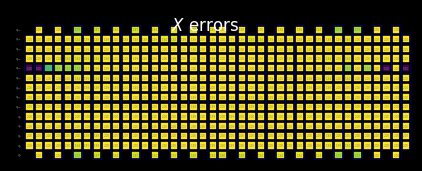

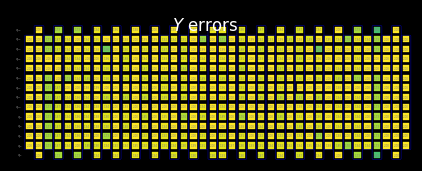

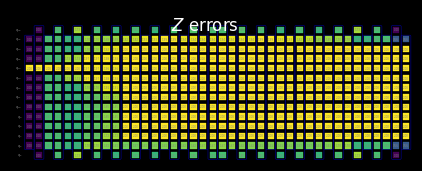

In [28]:
for p in "XYZ":
    display(
        draw_shaded_lightcone(
            boxed_circuit,
            backward_bounds,
            noise_model_paulis,
            pauli_filter=p,
            scale=0.15,
            fold=-1,
            idle_wires=False,
            wire_order=wire_order,
            measure_arrows=False,
        )
    )

#### Preview merged bounds without learned noise rates

The `merged_bounds` function determines the point in the circuit where switching from backward bounds to forward bounds minimizes the total estimated bias on the desired observable. This bias is computed as the sum of the backward-bound contributions for all noise locations before that point, plus the forward-bound contributions for all noise locations after it. Currently, this is done uniformly for all qubits.

> **Important Note**: The point to switch from forward to backward bounds depends on the learned noise rates.

In [29]:
merged_bounds = merge_bounds(
    boxed_circuit,
    forward_bounds_tighter,
    backward_bounds,
    noise_model_rates,
)

2026-02-02 11:17:13,757 WARNING merge Missing noise rates. Partitioning backward/forward commutator bounds by assuming uniform error rates.
2026-02-02 11:17:13,758 WARNING merge Optimal spacetime partitioning not implemented!Just partitioning list of noisy boxes.
2026-02-02 11:17:13,758 INFO merge Determined Box idx for partitioning to be 0.


### Visualize the SLC for manual inspection

After merging the backward and tightened forward bounds, the behavior of the combined SLCs becomes clear:

- The function above tells us that a partition is chosen at which the switch from backward to tightened forward bounds takes place.
- We can see below that the SLCs now contain partial backward and partial tightened forward bounds.

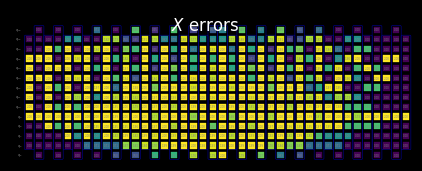

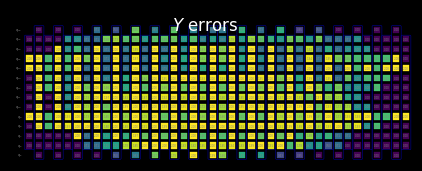

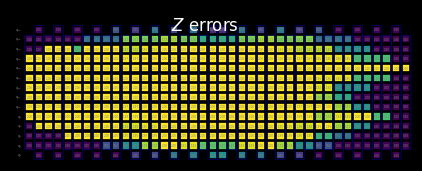

In [30]:
for p in "XYZ":
    display(
        draw_shaded_lightcone(
            boxed_circuit,
            merged_bounds,
            noise_model_paulis,
            pauli_filter=p,
            scale=0.15,
            fold=-1,
            idle_wires=False,
            wire_order=wire_order,
            measure_arrows=False,
        )
    )

## Step 3. Execute
In this section we begin the part of the workflow that uses a real quantum device. For this learning-based error mitigation method, there are two steps to this: 

1. Learn the noise by using `NoiseLeanerV3`.
2. Execute an error mitigation circuit with the new Samplomatic and Estimator framework. 

With the bounded errors from our quantum circuit, we must learn the associated noise rates to prioritize our error budget, determine the sampling overhead, and execute on a QPU. Further, with this noise rate information, we can also highlight how, by utilizing the strong compute resources from our cluster, we reduce sampling overhead while maintaining the same residual bias.

### a. Learn noise rates and execute in a single session

The noise learner allows characterization of the noise processes affecting the gates in one or more circuits of interest, based on the Pauli-Lindblad noise model described in the [Probabilistic error cancellation with sparse Pauli-Lindblad models on noisy quantum processors](https://arxiv.org/abs/2201.09866) paper. The `run()` method launches a noise-learning job for the provided unique 2-qubit layers, based on the options specified in the noise-learner configuration. In these options, you can adjust the Pauli-twirling strategy, which helps ensure that the hardware is well described by the Pauli-Lindblad noise model.

Details of your noise model are at risk of drifting over time. As such, we set a parameter to ensure the learned noise model is recomputed for experiments older than four hours. This is a rough rule-of-thumb and should be considered carefully when applying it to your own work.

In [31]:
post_selection_enabled = True
load_cached_noise_results = False

In [32]:
noise_learner_options = NoiseLearnerV3Options(
    num_randomizations=32,
    shots_per_randomization=64,
    layer_pair_depths=[1, 4, 8, 16, 24, 32, 40, 48],
    post_selection={
        "enable": post_selection_enabled,
        "strategy": "edge",
        "x_pulse_type": "rx",
    },
)

# Testing how we can combine these things

In [33]:
from qiskit_ibm_runtime import Session
import time
print("Initiating Session....")
with Session(backend=backend) as session:
    noise_learner = NoiseLearnerV3(options=noise_learner_options,mode=session)
    noise_learner_job = noise_learner.run(unique_2q_instructions)
    print ("Noise Learner Job Running")
    start = time.perf_counter()
    #####-----------------------------------------------------------------------------------------------
    noise_learner_result = noise_learner_job.result()
    print ("Noise Learner Job Complete")
    refs_2_plm = noise_learner_result.to_dict(unique_2q_instructions, require_refs=False)
    
    merged_bounds = merge_bounds(
        boxed_circuit,
        forward_bounds_tighter,
        backward_bounds,
        refs_2_plm,
    )
    
    chosen_bias_thres = 0.1
    local_scales, sampling_cost, residual_bias_bound = compute_local_scales(
        boxed_circuit,
        merged_bounds,
        refs_2_plm,
        sampling_cost_budget=np.inf,
        bias_tolerance=chosen_bias_thres,
    )
    
    template_circuit, samplex = samplomatic.build(boxed_circuit)
    
    
    post_selection_pm = PassManager(
        [
            AddSpectatorMeasures(backend.coupling_map),
            AddPostSelectionMeasures(x_pulse_type="rx"),
        ]
    )
    final_template_circuit = post_selection_pm.run(template_circuit)
    
    
    num_randomizations = 4000
    shots_per_randomization = 64
    chunk_size = 30
    # Set up QuantumProgram
    program = QuantumProgram(shots=shots_per_randomization, noise_maps=refs_2_plm)
    
    # no EM
    
    # Collect up a dict of the other arguments that need to be bound to samplex_inputs
    samplex_inputs = {f"noise_scales.{ref}": float(0) for ref in local_scales}
    samplex_inputs |= {"basis_changes": {"basis0": bases_canon[0]}}
    
    # Convert samplex_inputs into a dict to pass to QuantumProgram
    samplex_arguments = samplex.inputs().bind(**samplex_inputs).make_broadcastable()
    
    program.append(
        circuit=final_template_circuit,
        samplex=samplex,
        samplex_arguments=samplex_arguments,
        shape=(num_randomizations,),
        chunk_size=chunk_size,
    )
    
    # plain PEC
    
    # Collect a dict of the other arguments that need to be bound to samplex_inputs
    samplex_inputs = {f"noise_scales.{ref}": float(-1) for ref in local_scales}
    samplex_inputs |= {"basis_changes": {"basis0": bases_canon[0]}}
    
    # Convert samplex_inputs into a dict to pass to QuantumProgram
    samplex_arguments = samplex.inputs().bind(**samplex_inputs).make_broadcastable()
    
    program.append(
        circuit=final_template_circuit,
        samplex=samplex,
        samplex_arguments=samplex_arguments,
        shape=(num_randomizations,),
        chunk_size=chunk_size,
    )
    
    # PEC+SLC
    
    # Collect a dict of the other arguments that need to be bound to samplex_inputs
    samplex_inputs = {f"noise_scales.{ref}": float(-1) for ref in local_scales}
    samplex_inputs |= {"basis_changes": {"basis0": bases_canon[0]}}
    samplex_inputs |= {"local_scales": local_scales}
    
    # Convert samplex_inputs into a dict to pass to QuantumProgram
    samplex_arguments = samplex.inputs().bind(**samplex_inputs).make_broadcastable()
    
    program.append(
        circuit=final_template_circuit,
        samplex=samplex,
        samplex_arguments=samplex_arguments,
        shape=(num_randomizations,),
        chunk_size=chunk_size,
    )
    executor = Executor(mode=session)
    #####-----------------------------------------------------------------------------------------------
    
    end = time.perf_counter()
    print(f"Elapsed time: {end - start:.5f} seconds")
    job_exec = executor.run(program)


Initiating Session....
Noise Learner Job Running


2026-02-02 11:21:16,918 WARNING merge Optimal spacetime partitioning not implemented!Just partitioning list of noisy boxes.
2026-02-02 11:21:16,919 INFO merge Determined Box idx for partitioning to be 0.
2026-02-02 11:21:17,000 INFO base_tasks Pass: AddSpectatorMeasures - 1.90616 (ms)
2026-02-02 11:21:17,002 INFO base_tasks Pass: AddPostSelectionMeasures - 1.52397 (ms)


Noise Learner Job Complete
Elapsed time: 221.74084 seconds


In [34]:
job_exec.job_id()

'd600k857fc0s73auhid0'

In [36]:
job_exec.status()

'RUNNING'

In [37]:
results_exec = job_exec.result()

## Step 4. Post-process
As we calculate the final expectation value of interest by using `expectation_values`, we will implement a few beneficial post-processing techniques to help ensure we obtain the highest-quality results possible. First, we apply our [twirled readout mitigation, TREX](https://quantum.cloud.ibm.com/docs/guides/error-mitigation-and-suppression-techniques#twirled-readout-error-extinction-trex), which accounts for any errors occurring during the readout process. Then, we fix errors due to non-Markovian noise on our Heron backends by using a post-selection method. This method measures active and spectator qubits, then applies a slow rotation to each qubit, and then measures again. In instances where the two measurements do not confirm a flipped qubit as expected, these shots are discarded by applying a `mask` from the `PostSelector` function. Within the mask computation, a specific strategy can be set to filter based on single-qubit nodes or neighboring spectator edges, which can influence both the number of shots filtered out and the quality of the results.


In [38]:
id_map = map_modifier_ref_to_ref(boxed_circuit)

In [39]:
measurement_noise_map = noise_learner_result[2].to_pauli_lindblad_map()
trex_scale_factors = trex_factors(measurement_noise_map, reverser_virt)

In [40]:
post_selection_strategy = "edge"

In [41]:
def post_process_conv(datum, steps=16, gamma=None, ps=False, trex=False):
    meas = datum["meas"]
    flips = datum["measurement_flips.meas"]
    signs = datum.get("pauli_signs", None)

    meas_basis_axis = None
    avg_axis = 0

    mask = None
    if ps and post_selection_enabled:
        # Post-select the results
        post_selector = PostSelector.from_circuit(
            circuit=final_template_circuit, coupling_map=backend.coupling_map
        )

        # Compute the ps mask for filtering results
        mask = post_selector.compute_mask(datum, strategy=post_selection_strategy)

        # Compute fraction of shots kept from post selection
        total_num_shots = num_randomizations * shots_per_randomization
        ps_ratio = np.sum(mask) * 100 / total_num_shots / len(bases_canon)
        print(
            f"With {post_selection_strategy}-based post selection ({ps_ratio:.1f}% of shots kept):"
        )

    results = []
    for i in range(steps, num_randomizations + 1, steps):
        # Compute mitigated expvals w/out postselectoion
        res = executor_expectation_values(
            meas[:i],
            reverser_virt,
            meas_basis_axis,
            avg_axis=avg_axis,
            measurement_flips=flips[:i],
            pauli_signs=signs[:i] if signs is not None else None,
            postselect_mask=mask[:i] if mask is not None else None,
            rescale_factors=trex_scale_factors if trex else None,
            gamma_factor=gamma,
        )
        results.append(res[0])
    return results

In [42]:
gamma_pec = gamma_from_noisy_boxes(refs_2_plm, id_map)
gamma_slc = gamma_from_noisy_boxes(refs_2_plm, id_map, local_scales)

In [43]:
steps = 16

In [44]:
results = {}

for label, result_idx, gamma, use_ps, use_trex in [
    ("PEC", 1, gamma_pec, True, True),
    ("PEC+SLC", 2, gamma_slc, True, True),
    ("Unmitigated", 0, None, False, False),
]:
    res = post_process_conv(
        results_exec[result_idx], steps=steps, gamma=gamma, ps=use_ps, trex=use_trex
    )
    results[label] = res

With edge-based post selection (85.5% of shots kept):
With edge-based post selection (85.6% of shots kept):


From examination of the experimental results, we can directly compare the behavior of different approaches: PEC, PEC combined with SLC, and the baseline of unmitigated results. Some specific details to highlight:

- Unmitigated results remain outside the desired bias range and are unaffected by sampling overhead.
- Given the high sampling cost computed above (~10k), PEC alone does not converge within the limits of randomization used.
- PEC + SLC, in contrast, converges much more quickly.
- The error bounds also decrease significantly faster for PEC + SLC than for plain PEC.



(-50.0, 4100.0)

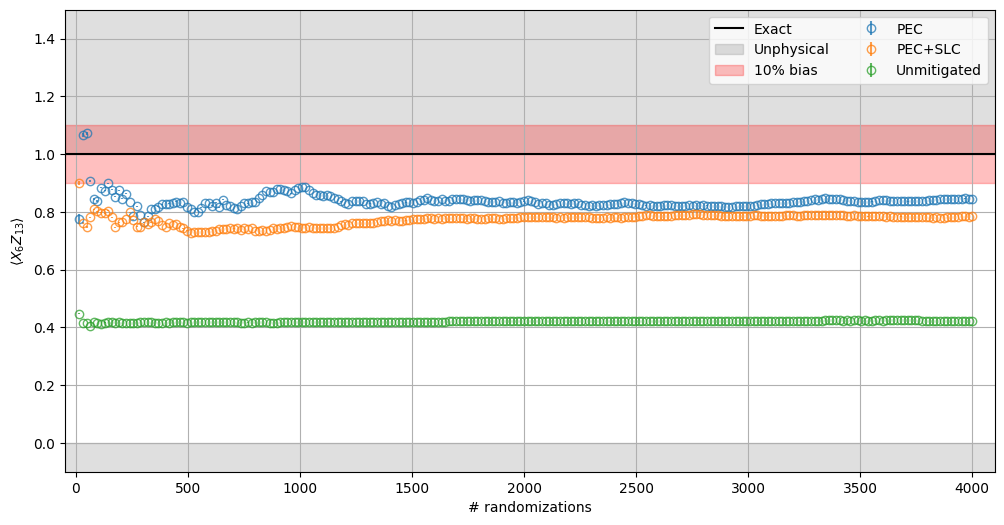

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.axhline(1.0, color="black", label="Exact")
ax.fill_between([-50, 4100], -10, 0, color="grey", alpha=0.25, label="Unphysical")
ax.fill_between([-50, 4100], 1, 10, color="grey", alpha=0.25)
ax.fill_between([-50, 4100], 0.9, 1.1, color="red", alpha=0.25, label="10% bias")

for label, res in results.items():
    ax.errorbar(
        list(range(steps, num_randomizations + 1, steps)),
        [r[0] for r in res],
        yerr=[r[1] for r in res],
        alpha=0.75,
        marker="o",
        linestyle="",
        markerfacecolor="none",
        label=label,
    )

ax.set_ylabel(r"$\langle X_{6}Z_{13}\rangle$")
ax.set_xlabel("# randomizations")
ax.grid()

ax.legend(ncols=2)
ax.set_ylim([-0.1, 1.5])
ax.set_xlim([-50, 4100])